In [21]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pandas as pd

# Setup

In [22]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 07/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig7'

In [76]:
events_path = '../data_copies/SWs_and_EMs/'
scores_path = '../formatted_scores/'

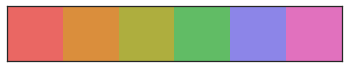

In [24]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")


In [25]:
# Other plot formatting
figsize_hist = (4,4)
axis_label_fontsize = 24

# Dot formatting
alpha_main = 0.2
alpha_darker = 0.3

# Line formatting
linewidth = 5
linealpha = .7

hist_linewidth=3

In [26]:
epochLength = 3
birds = np.arange(1,6)
stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stage_nums = [3,4,5]   # sleep stages to plot
sr = 200

epochLengthPts = epochLength*sr

# Load data

## Scores

In [27]:
AllScores = {}
for b in birds:
    scores_file = 'All_scores_Bird {}.csv'.format(b)
    AllScores[b] = pd.read_table(scores_path + scores_file, sep=',', index_col=0)

## Slow waves

In [28]:
def load_SWs(b):
    birdPath = '0{}_Bird_{}_SW_EM_detected/'.format(b,b)
    path = events_path + birdPath

    all_ch_data = {}   # init

    for file in os.listdir(path):
        if 'SWs' in file:
            # Get channel
            ch_tmp = file.split('_')[-1]
            ch = ch_tmp.split('.')[0]
            ch_data = pd.read_table(path+file, sep=',', index_col=0)

            if ch in all_ch_data.keys():
                all_ch_data[ch] = all_ch_data[ch].append(ch_data)
            else:
                all_ch_data[ch] = ch_data

    channel_names = list(all_ch_data.keys())
    
    return(all_ch_data)

## EM artifacts

In [29]:
def load_EM_artifacts(b):
    birdPath = '0{}_Bird_{}_SW_EM_detected/'.format(b,b)
    path = events_path + birdPath

    all_ch_data = {}   # init

    for file in os.listdir(path):
        if 'EMartifacts' in file:
            # Get channel
            ch_tmp = file.split('_')[-1]
            ch = ch_tmp.split('.')[0]
            ch_data = pd.read_table(path+file, sep=',', index_col=0)

            if ch in all_ch_data.keys():
                all_ch_data[ch] = all_ch_data[ch].append(ch_data)
            else:
                all_ch_data[ch] = ch_data

    channel_names = list(all_ch_data.keys())
    
    return(all_ch_data)

## Eye movements

In [30]:
def load_EMs(b):
    birdPath = '0{}_Bird_{}_SW_EM_detected/'.format(b,b)
    path = events_path + birdPath

    data = pd.DataFrame([])

    for file in os.listdir(path):
        if 'EMs' in file:
            data = data.append(pd.read_table(path+file, sep=',', index_col=0))
            
    return(data)

# Organize data

## Assign each event to an epoch

In [31]:
def assign_epoch(data):
    '''data: a single Dataframe (eg, for SWs, must provide all_ch_data[ch])'''

    epochID = np.floor(data['Start'] / epochLength)
    data['Epoch # start'] = epochID
    data['Epoch #'] = epochID
    epochID = np.floor(data['Stop'] / epochLength)
    data['Epoch # stop'] = epochID
    data['Length'] = data['Stop'] - data['Start']
    
    # Detect & split overlaps (ie events spanning more than one epoch)
    overlaps = data[data['Epoch # start'] != data['Epoch # stop']]
    non_overlaps_tmp = data[data['Epoch # start'] == data['Epoch # stop']]
    non_overlaps = non_overlaps_tmp[['Label', 'Epoch #', 'Start', 'Stop', 'Length']]

    # Dataframe for first half of event
    overlaps_first_ep = pd.DataFrame(overlaps[['Label', 'Epoch #', 'Start']])
    overlaps_first_ep['Stop'] = epochLength * overlaps['Epoch # stop'].values
    overlaps_first_ep['Length'] = overlaps_first_ep['Stop'] - overlaps_first_ep['Start']

    # Dataframe for second half of event
    overlaps_second_ep = pd.DataFrame(overlaps[['Label']])
    overlaps_second_ep['Epoch #'] = overlaps['Epoch # stop'].values
    overlaps_second_ep['Start'] = epochLength * overlaps['Epoch # stop'].values
    overlaps_second_ep['Stop'] = overlaps['Stop'].values
    overlaps_second_ep['Length'] = overlaps_second_ep['Stop'] - overlaps_second_ep['Start']

    # Concatenate non-overlaps with the split events
    data = pd.concat([overlaps_first_ep, overlaps_second_ep, non_overlaps], ignore_index=True)
    data = data.sort_values(by='Start')
    data = data.reset_index(drop=True)
    
    return(data)

## Collapse events across channels

In [32]:
def collapse_across_ch(all_ch_data):

    # Get all points encompassed by SWs (or EM artifacts) in each channel

    event_points_all = np.array([])    # init
    channel_names = all_ch_data.keys()
    nChannels = len(channel_names)

    for ch in channel_names:
        data = all_ch_data[ch]

        event_points_ch = np.array([])   # init

        for event in range(len(data)):
            start_pts = data['Start'][event]
            stop_pts  = data['Stop'][event]
            range_pts = np.arange(start_pts, stop_pts, 1/sr)
            event_points_ch = np.append(event_points_ch, range_pts)

        event_points_all = np.append(event_points_all, event_points_ch)

    ### Sum to get total time of all channels (i.e., max time is nChannels x epochLength)
    # Assign epochs
    Event_Points_All = pd.DataFrame(event_points_all, columns=['Point (s)'])

    Event_Points_All['Epoch #'] = np.floor(Event_Points_All['Point (s)'] / epochLength)

    # Sum to get total s / epoch of the event
    # Divide by num of channels
    events_all_sec_avg_per_ch = (1/sr)*pd.value_counts(Event_Points_All['Epoch #'].values, sort=False)/nChannels
      
        
    ### Collapse to get total time that a SW is on any channel (i.e., max time is epochLength)
    # Round to get rid of numerical errors 
    event_points_all = np.round(event_points_all, 3)
    
    # Remove repetitions to get all unique points encompassed by a SW, in any channel
    event_points_all = np.unique(event_points_all)

    # Assign epochs
    Event_Points_All = pd.DataFrame(event_points_all, columns=['Point (s)'])

    Event_Points_All['Epoch #'] = np.floor(Event_Points_All['Point (s)'] / epochLength)

    # Sum to get total s / epoch of the event
    event_all_sec_per_epoch = (1/sr)*pd.value_counts(Event_Points_All['Epoch #'].values, sort=False)
    
    return(event_all_sec_per_epoch, events_all_sec_avg_per_ch)

## Calculate EM stats

In [33]:
def EM_stats(data):
    EMs_per_epoch = pd.value_counts(data['Epoch #'].values, sort=False)

    EM_sec_per_epoch = data.groupby(['Epoch #'])['Length'].sum() ## currently using this one

    EM_med_sec_per_epoch = data.groupby(['Epoch #'])['Length'].median()

    EM_mean_sec_per_epoch = data.groupby(['Epoch #'])['Length'].mean()
    
    return(EMs_per_epoch, EM_sec_per_epoch, EM_med_sec_per_epoch, EM_mean_sec_per_epoch)

## Make dataframe with per-epoch info on SWs and EMs

In [34]:
def get_SWs_EMs_by_epoch(Scores, bird_SWs, bird_EM_artifacts,
                         SW_all_sec_per_epoch, SW_all_sec_avg_per_ch,
                         EM_sec_per_epoch, EM_med_sec_per_epoch, EM_mean_sec_per_epoch):

    all_epochs = pd.DataFrame([],index=np.arange(0,
                                              max(Scores['Epoch #'])))

    all_epochs['SW s'] = SW_all_sec_per_epoch
    all_epochs['SW s all ch'] = SW_all_sec_avg_per_ch
    all_epochs['EM s'] = EM_sec_per_epoch
     
    # per-channel SW stats
    for ch in bird_SWs.keys():
        _, SW_s_per_epoch, _, _ = EM_stats(bird_SWs[ch])
        all_epochs['SW s: ' + ch] = SW_s_per_epoch
    
    # per-channel EM artifact stats
    for ch in bird_EM_artifacts.keys():
        _, artifact_s_per_epoch, _, _ = EM_stats(bird_EM_artifacts[ch])
        all_epochs['EM artifact s: ' + ch] = artifact_s_per_epoch

    # replace NaN's with 0
    all_epochs = all_epochs.fillna(value=0)

    all_epochs['EM med'] = EM_med_sec_per_epoch
    all_epochs['EM mean'] = EM_mean_sec_per_epoch

    # add sleep scores

    Scores_by_epoch = pd.Series(Scores['Label (#)'].values, index=Scores['Epoch #'].values)

    all_epochs = all_epochs.join(pd.DataFrame(Scores_by_epoch, columns=['Label (#)']))
    
    return(all_epochs)

# Plot: individual birds

## SW histogram

In [35]:
def SW_histogram(all_epochs, birdToRun, savePlots=False):

    plt.figure(figsize=figsize_hist)

    for stage in stage_nums:

        tmp_epStage = all_epochs[all_epochs["Label (#)"]==stage].index.values
        tmp_Stage = all_epochs.loc[tmp_epStage]

        plot_color = colors[stage]

        hist = plt.hist(tmp_Stage['SW s'], bins=50, density=True, color=plot_color, label=stages[stage], 
                        histtype='step', lw=hist_linewidth, alpha=linealpha);

    plt.xlim(0,3)
    plt.ylim(0,1.5)

    plt.xlabel('s of SWs/epoch')
    plt.ylabel('PDF')
    sns.despine()

    plt.suptitle(birdToRun)

    if savePlots:
        plt.savefig(saveAsPath + saveAsName + 'b_' + birdToRun + "_hist_SW_s_per_epoch" + '.pdf')
        
    return(hist)

## SW_histogram_per_ch

In [36]:
def SW_histogram_per_ch(all_epochs, birdToRun, savePlots=False):
    
    channels = [x for x in all_epochs.columns.values if 'SW s: ' in x]
    

    for stage in stage_nums:

        tmp_epStage = all_epochs[all_epochs["Label (#)"]==stage].index.values
        tmp_Stage = all_epochs.loc[tmp_epStage]

        plot_color = colors[stage]

        for ch in channels:
            hist = plt.hist(tmp_Stage[ch], bins=50, density=True, color=plot_color, label=stages[stage], 
                            histtype='step', lw=hist_linewidth, alpha=linealpha/2);

    plt.xlim(0,3)
    plt.ylim(0,2.5)

    plt.xlabel('s of SWs/epoch: per channel')
    plt.ylabel('PDF')
    sns.despine()

    plt.suptitle(birdToRun)

    #if savePlots:
    #    plt.savefig(saveAsPath + saveAsName + '_' + birdToRun + "_hist_SW_s_per_epoch_per_channel" + '.pdf')
        

## EM_artifact_histogram_per_ch

In [37]:
def EM_artifact_histogram_per_ch(all_epochs, birdToRun, savePlots=False):
    channels = [x for x in all_epochs.columns.values if 'EM artifact s: ' in x]
    

    for stage in stage_nums:

        tmp_epStage = all_epochs[all_epochs["Label (#)"]==stage].index.values
        tmp_Stage = all_epochs.loc[tmp_epStage]

        plot_color = colors[stage]

        for ch in channels:
            hist = plt.hist(tmp_Stage[ch], bins=50, density=True, color=plot_color, label=stages[stage], 
                            histtype='step', lw=hist_linewidth, alpha=linealpha/2);

    plt.xlim(0,3)
    plt.ylim(0,5)

    plt.xlabel('s of EM artifact/epoch: per channel')
    plt.ylabel('PDF')
    sns.despine()

    plt.suptitle(birdToRun)

    #if savePlots:
    #    plt.savefig(saveAsPath + saveAsName + '_' + birdToRun + "_hist_EMartifact_s_per_epoch_per_channel" + '.pdf')
        

    

## EM histogram

In [38]:
def EM_histogram(all_epochs, birdToRun, savePlots=False):

    plt.figure(figsize=figsize_hist)

    for stage in stage_nums:

        tmp_epStage = all_epochs[all_epochs["Label (#)"]==stage].index.values
        tmp_Stage = all_epochs.loc[tmp_epStage]

        plot_color = colors[stage]

        hist = plt.hist(tmp_Stage['EM s'], bins=50, density=True, color=plot_color, label=stages[stage], 
                        histtype='step', lw=hist_linewidth, alpha=linealpha);

    plt.xlabel('s of EMs per epoch')
    plt.ylabel('PDF')
    plt.suptitle(birdToRun)

    plt.xlim(0,3.0)
    plt.ylim(0,4)
    sns.despine()

    if savePlots:
        plt.savefig(saveAsPath + saveAsName + 'e_' + birdToRun + "_hist_EM_s_per_epoch" + '.pdf')
        
    return(hist)

# FIGURE 7B,E: Implement: loop through birds

In [39]:
AllBirds_per_epoch_info = {}
AllBirds_EM_hist = {}
AllBirds_SW_hist = {}

In [40]:
# fix rounding issue & multiply % epoch by epochLength
for b in birds:
    print(b)

    ## SCORES ##
    bird_scores = AllScores[b]

    ## EYE MOVEMENTS ##
    print('\t Eye movements')
    tmp_bird_EMs = load_EMs(b)
    bird_EMs = assign_epoch(tmp_bird_EMs)
    EMs_per_epoch, EM_s_per_epoch, EM_med_s_per_epoch, EM_mean_s_per_epoch = EM_stats(bird_EMs)

    ## SLOW WAVES ##
    print('\t SWs')
    tmp_bird_SWs = load_SWs(b)
    channels = tmp_bird_SWs.keys()
    bird_SWs = {}
    bird_SWs_s_per_epoch = pd.DataFrame([])
    for ch in channels:
        bird_SWs[ch] = assign_epoch(tmp_bird_SWs[ch])
    SW_s_per_epoch, SW_s_avg_channels = collapse_across_ch(bird_SWs)
    
    ## EM ARTIFACTS ##
    print('\t EM artifacts')
    tmp_bird_EM_artifacts = load_EM_artifacts(b)
    channels = tmp_bird_EM_artifacts.keys()
    bird_EM_artifacts = {}
    bird_EM_artifacts_s_per_ep = pd.DataFrame([])
    for ch in channels:
        ch_artifacts = tmp_bird_EM_artifacts[ch]
        ch_artifacts['Label'] = 'EM_artifact'
        bird_EM_artifacts[ch] = assign_epoch(ch_artifacts)
              

    ## PER-EPOCH INFO ##
    per_epoch_info = get_SWs_EMs_by_epoch(bird_scores, bird_SWs, bird_EM_artifacts,
                                          SW_s_per_epoch, SW_s_avg_channels,
                                          EM_s_per_epoch, EM_med_s_per_epoch, EM_mean_s_per_epoch)   

    ## SAVE VARIABLES ##
    AllBirds_per_epoch_info[b] = per_epoch_info
    #AllBirds_EM_hist[b] = EM_hist
    #AllBirds_SW_hist[b] = SW_hist

1
	 Eye movements
	 SWs


KeyboardInterrupt: 

In [ ]:
AllBirds_per_epoch_info[3]

## Save to csvs

In [ ]:
for b in birds: 
    per_epoch_info = AllBirds_per_epoch_info[b]
    per_epoch_info.to_csv(saveAsPath + saveAsName + '_Bird ' + str(b) + '_SW-EM-per-epoch.csv')

## Load from csvs

In [77]:
for b in birds:
    per_epoch_info = pd.read_csv((events_path + saveAsName + '_Bird ' + str(b) + '_SW-EM-per-epoch.csv'))
    AllBirds_per_epoch_info[b] = per_epoch_info

## Plot histograms without recalculating SW/EM per epoch

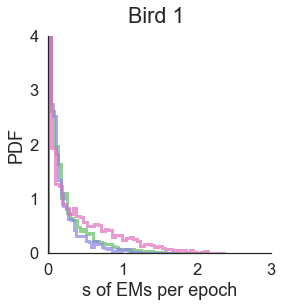

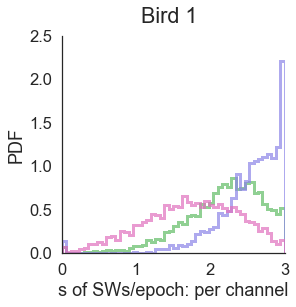

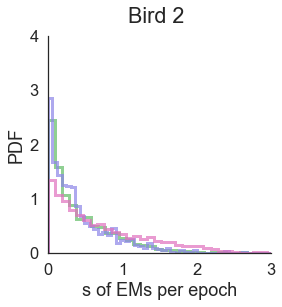

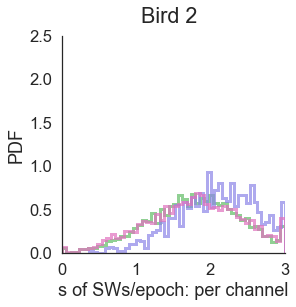

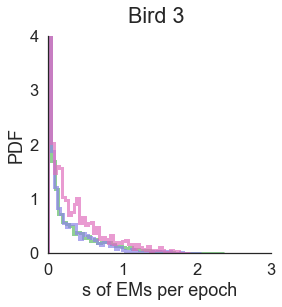

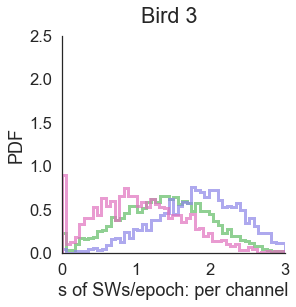

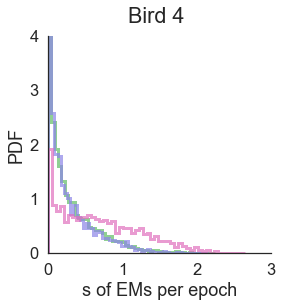

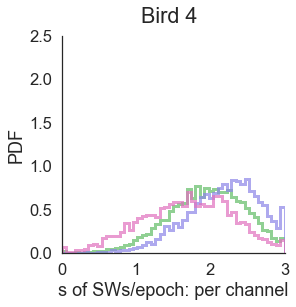

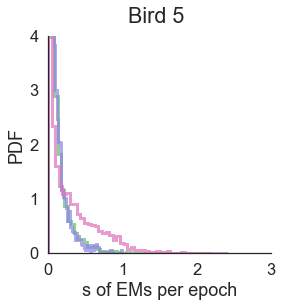

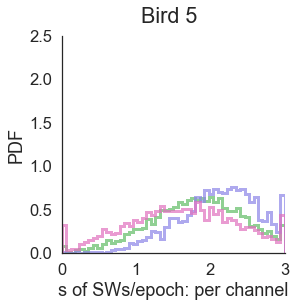

In [78]:
for b in birds:

    per_epoch_info = AllBirds_per_epoch_info[b]
    
    ## CALCULATE PLOTS FOR INDIVIDUAL BIRD ##
    EM_hist = EM_histogram(per_epoch_info, 'Bird '+str(b), savePlots=True)
    SW_hist = SW_histogram(per_epoch_info, 'Bird '+str(b), savePlots=True)
    SW_hist_per_ch = SW_histogram_per_ch(per_epoch_info, 'Bird '+str(b), savePlots=True)


# Plot: all birds

## SW histogram: each bird overlaid

Text(0.5, 0.98, 'All Birds')

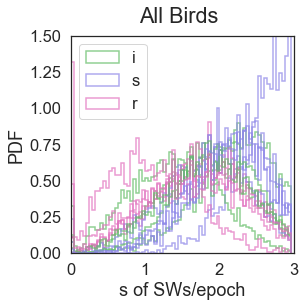

In [79]:
plt.figure(figsize=figsize_hist)

for b in birds:
    per_epoch_info = AllBirds_per_epoch_info[b]
    for stage in stage_nums:

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        plot_color = colors[stage]

        plt.hist(tmp_Stage['SW s'], bins=np.arange(0,3,1/25), density=True, color=plot_color, label=stages[stage], 
                    histtype='step', lw=hist_linewidth/2, alpha=linealpha);

    if b == 1:
        plt.legend(loc='upper left')
        
plt.xlim(0,3)
plt.ylim(0,1.5)

plt.xlabel('s of SWs/epoch')
plt.ylabel('PDF')

plt.suptitle("All Birds")

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "_hist_SW_s_per_epoch" + '.pdf')

Text(0.5, 0.98, 'All Birds')

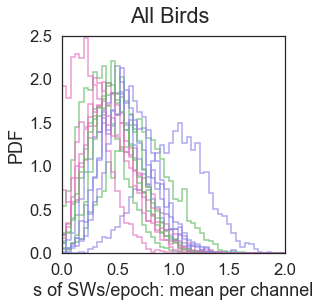

In [80]:
plt.figure(figsize=figsize_hist)

for b in birds:
    per_epoch_info = AllBirds_per_epoch_info[b]
    for stage in stage_nums:

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        plot_color = colors[stage]

        plt.hist(tmp_Stage['SW s all ch'], bins=np.arange(0,3,1/25), density=True, color=plot_color, label=stages[stage], 
                    histtype='step', lw=hist_linewidth/2, alpha=linealpha);

        
plt.xlim(0,2)
plt.ylim(0,2.5)

plt.xlabel('s of SWs/epoch: mean per channel')
plt.ylabel('PDF')

plt.suptitle("All Birds")

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "_hist_SW_s_per_epoch_per_ch" + '.pdf')

## FIGURE 7C: SW histogram: grand mean s/epoch

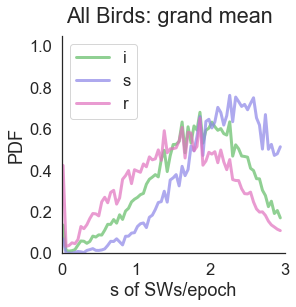

In [81]:
plt.figure(figsize=figsize_hist)

bin_edges = np.arange(0,3,1/25)
bin_centers = np.arange(1/50, 3 - 1/25, 1/25)

for stage in stage_nums:
    grand_mean_stage_hist = np.zeros_like(bin_centers)
    
    for b in birds:
        per_epoch_info = AllBirds_per_epoch_info[b]

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        bird_stage_hist = np.histogram(tmp_Stage['SW s'], bins=bin_edges, density=True)
        
        grand_mean_stage_hist = grand_mean_stage_hist + bird_stage_hist[0]
        
    grand_mean_stage_hist = grand_mean_stage_hist/(len(birds))
    
    plot_color = colors[stage]
    
    plt.plot(bin_centers, grand_mean_stage_hist, color=plot_color, label=stages[stage], 
                    lw=hist_linewidth, alpha=linealpha);

plt.xlim(0,3)
plt.ylim(0,1.05)

plt.xlabel('s of SWs/epoch')
plt.ylabel('PDF')

plt.legend()
sns.despine()

plt.suptitle("All Birds: grand mean")

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "c_hist_SW_s_per_epoch_GRANDMEAN" + '.pdf')

### save to csv

In [91]:
if saveData:
    for stage in stage_nums:
        grand_mean_stage_hist = pd.DataFrame([], index=bin_centers)
    
        for b in birds:
            per_epoch_info = AllBirds_per_epoch_info[b]
            tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
            tmp_Stage = per_epoch_info.loc[tmp_epStage]

            bird_stage_hist = np.histogram(tmp_Stage['SW s'], bins=bin_edges, density=True)
            
            grand_mean_stage_hist['Bird ' + str(b)] = bird_stage_hist[0]

        grand_mean_stage_hist.to_csv(saveAsPath + saveAsName + "c_hist_SW_s_per_epoch_stage_" + stages[stage] + '.csv')

Text(0.5, 0.98, 'All Birds: grand mean')

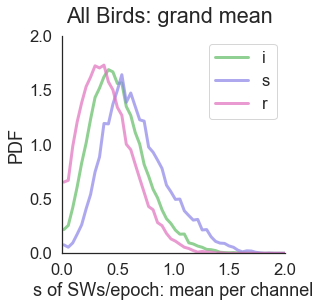

In [83]:
plt.figure(figsize=figsize_hist)

bin_edges = np.arange(0,3,1/25)
bin_centers = np.arange(1/50, 3 - 1/25, 1/25)

for stage in stage_nums:
    grand_mean_stage_hist = np.zeros_like(bin_centers)
    
    for b in birds:
        per_epoch_info = AllBirds_per_epoch_info[b]

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        bird_stage_hist = np.histogram(tmp_Stage['SW s all ch'], bins=bin_edges, density=True)
        
        grand_mean_stage_hist = grand_mean_stage_hist + bird_stage_hist[0]
        
    grand_mean_stage_hist = grand_mean_stage_hist/(len(birds))
    
    plot_color = colors[stage]
    
    plt.plot(bin_centers, grand_mean_stage_hist, color=plot_color, label=stages[stage], 
                    lw=hist_linewidth, alpha=linealpha);

plt.xlim(0,2)
plt.ylim(0,2)

plt.xlabel('s of SWs/epoch: mean per channel')
plt.ylabel('PDF')

plt.legend()
sns.despine()

plt.suptitle("All Birds: grand mean")

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "_hist_SW_s_per_epoch_per_channel_GRANDMEAN" + '.pdf')

In [92]:
if saveData:
    for stage in stage_nums:
        grand_mean_stage_hist = pd.DataFrame([], index=bin_centers)
    
        for b in birds:
            per_epoch_info = AllBirds_per_epoch_info[b]
            tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
            tmp_Stage = per_epoch_info.loc[tmp_epStage]

            bird_stage_hist = np.histogram(tmp_Stage['SW s all ch'], bins=bin_edges, density=True)
            
            grand_mean_stage_hist['Bird ' + str(b)] = bird_stage_hist[0]

        grand_mean_stage_hist.to_csv(saveAsPath + saveAsName + "_hist_SW_s_mean_per_channel_per_epoch_stage_" + stages[stage] + '.csv')

## EM histogram: each bird overlaid

Text(0.5, 0.98, 'All Birds')

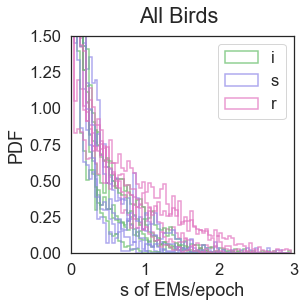

In [84]:
plt.figure(figsize=figsize_hist)

for b in birds:
    per_epoch_info = AllBirds_per_epoch_info[b]
    for stage in stage_nums:

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        plot_color = colors[stage]

        plt.hist(tmp_Stage['EM s'], bins=np.arange(0,3,1/25), density=True, color=plot_color, label=stages[stage], 
                    histtype='step', lw=hist_linewidth/2, alpha=linealpha);

    if b == 1:
        plt.legend()
        
plt.xlim(0,3)
plt.ylim(0,1.5)

plt.xlabel('s of EMs/epoch')
plt.ylabel('PDF')

plt.suptitle("All Birds")

#if savePlots:
    #plt.savefig(saveAsPath + saveAsName + "_hist_EM_s_per_epoch" + '.pdf')


## FIGURE 7F: EM histogram: grand mean s/epoch

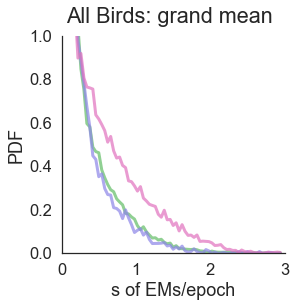

In [85]:
plt.figure(figsize=figsize_hist)

bin_edges = np.arange(0,3,1/25)
bin_centers = np.arange(1/50, 3 - 1/25, 1/25)

for stage in stage_nums:
    grand_mean_stage_hist = np.zeros_like(bin_centers)
    
    for b in birds:
        per_epoch_info = AllBirds_per_epoch_info[b]

        tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
        tmp_Stage = per_epoch_info.loc[tmp_epStage]

        bird_stage_hist = np.histogram(tmp_Stage['EM s'], bins=bin_edges, density=True)
        
        grand_mean_stage_hist = grand_mean_stage_hist + bird_stage_hist[0]
        
    grand_mean_stage_hist = grand_mean_stage_hist/(len(birds))
    
    plot_color = colors[stage]
    
    plt.plot(bin_centers, grand_mean_stage_hist, color=plot_color, label=stages[stage], 
                    lw=hist_linewidth, alpha=linealpha);

plt.xlim(0,3)
plt.ylim(0,1)

plt.xlabel('s of EMs/epoch')
plt.ylabel('PDF')

#plt.legend()
sns.despine()

plt.suptitle("All Birds: grand mean")

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "f_hist_EM_s_per_epoch_GRANDMEAN" + '.pdf')

### save to csv

In [89]:
if saveData:
    for stage in stage_nums:
        grand_mean_stage_hist = pd.DataFrame([], index=bin_centers)
    
        for b in birds:
            per_epoch_info = AllBirds_per_epoch_info[b]
            tmp_epStage = per_epoch_info[per_epoch_info["Label (#)"]==stage].index.values
            tmp_Stage = per_epoch_info.loc[tmp_epStage]

            bird_stage_hist = np.histogram(tmp_Stage['EM s'], bins=bin_edges, density=True)
            
            grand_mean_stage_hist['Bird ' + str(b)] = bird_stage_hist[0]

        grand_mean_stage_hist.to_csv(saveAsPath + saveAsName + "f_hist_EM_s_per_epoch_stage_" + stages[stage] + '.csv')